In [1]:
import zipfile
local_zip = '/content/archive (2).zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [2]:
import os
dataset_home = 'dataset/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
 
 labeldirs = ['cardboard/', 'glass/','metal/','paper/','plastic/','trash/']
 for labldir in labeldirs:
  newdir = dataset_home + subdir + labldir
  os.makedirs(newdir, exist_ok=True)

In [14]:
from random import random
from shutil import copyfile
val_ratio = 0.25
src_directory = '/content/Garbage classification/Garbage classification'
for file in os.listdir(src_directory):
  src = os.path.join(src_directory,file)
  for img in os.listdir(src):
    main = os.path.join(src,img)
    dst_dir = 'train/'
    if random() < val_ratio:
      dst_dir = 'test/'
    if file.startswith('cardboard'):
      dst = dataset_home + dst_dir + 'cardboard/'  + img
      copyfile(main, dst)
    elif file.startswith('glass'):
      dst = dataset_home + dst_dir + 'glass/'  + img
      copyfile(main ,dst)
    elif file.startswith('metal'):
      dst = dataset_home + dst_dir + 'metal/'  + img
      copyfile(main, dst)
    elif file.startswith('paper'):
      dst = dataset_home + dst_dir + 'paper/'  + img
      copyfile(main, dst)
    elif file.startswith('plastic'):
      dst = dataset_home + dst_dir + 'plastic/'  + img
      copyfile(main, dst)
    elif file.startswith('trash'):
      dst = dataset_home + dst_dir + 'trash/'  + img
      copyfile(main, dst)

In [16]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [15]:
def find_classes(directory: str):
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

  if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [17]:
find_classes(train_dir)

(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
 {'cardboard': 0,
  'glass': 1,
  'metal': 2,
  'paper': 3,
  'plastic': 4,
  'trash': 5})

In [18]:
find_classes(test_dir)

(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
 {'cardboard': 0,
  'glass': 1,
  'metal': 2,
  'paper': 3,
  'plastic': 4,
  'trash': 5})

In [54]:
import torch
from torch import nn 
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) :
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [45]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [46]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fb85af07670>,
 <__main__.ImageFolderCustom at 0x7fb85af07f40>)

In [47]:
len(train_data_custom), len(test_data_custom)

(1920, 607)

In [48]:
class_names = train_data_custom.classes
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [49]:
train_data_custom.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [50]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


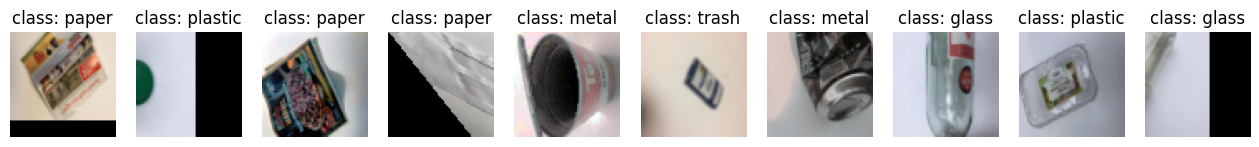

In [51]:
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None)

In [52]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=16, 
                                     num_workers=0, 
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=16, 
                                    num_workers=0, 
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fb85d348490>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb85d38b940>)

In [53]:
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


In [56]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_custom.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=6, bias=True)
  )
)

In [57]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [58]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [59]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [61]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5704 | train_acc: 0.3344 | test_loss: 1.4733 | test_acc: 0.3876
Epoch: 2 | train_loss: 1.5713 | train_acc: 0.3370 | test_loss: 1.4846 | test_acc: 0.3840
Epoch: 3 | train_loss: 1.5528 | train_acc: 0.3505 | test_loss: 1.4214 | test_acc: 0.3742
Epoch: 4 | train_loss: 1.5276 | train_acc: 0.3818 | test_loss: 1.3358 | test_acc: 0.4633
Epoch: 5 | train_loss: 1.4649 | train_acc: 0.3953 | test_loss: 1.2783 | test_acc: 0.4978
Epoch: 6 | train_loss: 1.4703 | train_acc: 0.3870 | test_loss: 1.2545 | test_acc: 0.5161
Epoch: 7 | train_loss: 1.4433 | train_acc: 0.4089 | test_loss: 1.2337 | test_acc: 0.5148
Epoch: 8 | train_loss: 1.4331 | train_acc: 0.4208 | test_loss: 1.2043 | test_acc: 0.5405
Epoch: 9 | train_loss: 1.4175 | train_acc: 0.4385 | test_loss: 1.1865 | test_acc: 0.5257
Epoch: 10 | train_loss: 1.3980 | train_acc: 0.4375 | test_loss: 1.1745 | test_acc: 0.5739
Epoch: 11 | train_loss: 1.4039 | train_acc: 0.4562 | test_loss: 1.1620 | test_acc: 0.5422
Epoch: 12 | train_l

In [63]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

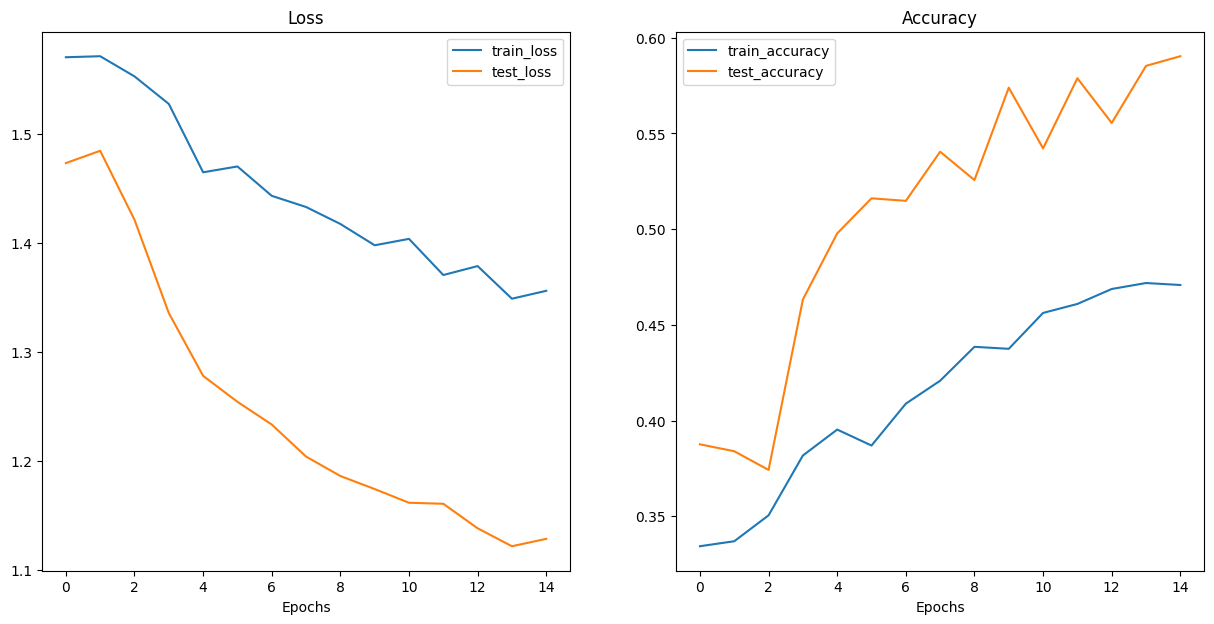

In [64]:
plot_loss_curves(model_0_results)